# Reproducing Villena-Gonzalez CDA Study (2019)
# Bipolar Ref

## Notes
Gives exactly the same thing as the with other reference(s) config.

In [25]:
import numpy as np
import glob
import pickle

import mne
from mne import Epochs, pick_channels, find_events
from mne.io import read_raw_bdf

import sys
sys.path.append('/Users/nick/Documents/PhD/CLCT/reprod/studies/Villena-Gonzalez-2019/')
from events import get_specific_events, get_epochs, get_CDA, prep_report, fill_report, get_report, checksum
 
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Prep Data

In [26]:
#==================================================================
# General Variables
#==================================================================
## Organize Triggers
triggers = dict();

# --------------------------
triggers['1'] = [10,11,12,13] 
triggers['2'] = [20,21,22,23]
triggers['4'] = [40,41,42,43]

triggers['left'] = [11,12,21,22,41,42]
triggers['right'] = [10,13,20,23,40,43]

triggers['good'] = [60]
triggers['bad'] = [61]

# Labels
conds = ['1', '2', '4']
sides = ['left', 'right']
perfs = ['good', 'bad']

# CDA Channels
chan_right = ['TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2']
chan_left =  ['TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1']

# Epoch information
epoch_length = 1.6
epoch_tmin = -0.4
baseline_corr = (-0.4, -0.2)

# CDA main variable!
cda_dict = dict()
report = prep_report(conds, sides, perfs)

#==================================================================
# Main Loop - Loading All Files & Extract CDAs.
#==================================================================
#directory_path = 'D:\\CLNT\\Data\\Open Datasets\\Villena-Gonzalez 2019\\Data\\'
directory_path = '/Users/nick/Documents/PhD/CDA Datasets/Villena-Gonzalez 2019/Data/'
sep = '/'

for filepath in glob.iglob(directory_path + '*.bdf'):
    filename = filepath[filepath.rfind(sep)+1:]
    print('Processing: ' + filename + '...')
   
    # ------------------------
    # 1. -- Load File --
    # ------------------------
    raw = read_raw_bdf(filepath, preload=True)

    # ------------------------
    # 2. -- Preprocessing --
    # ------------------------
    # Keep only EEG channels and reference
    #raw = raw.rename_channels({'EXG7':'A1', 'EXG8': 'A2'})
    #raw = raw.drop_channels(ch_names=['EXG1','EXG2','EXG3','EXG4','EXG5','EXG6'])
    #raw = raw.set_eeg_reference(ref_channels=['EXG7', 'EXG8'])
    #raw = raw.set_channel_types({'EXG7': 'misc', 'EXG8': 'misc'})
      
    # Set Electrodes Locations
    #montage = mne.channels.make_standard_montage('biosemi64')
    #raw.set_montage(montage)
    
    # Resample
    preproc = raw.resample(1024)

    # Filter
    preproc = preproc.filter(.1, 20., fir_design='firwin', skip_by_annotation='edge')

    # Events
    events = find_events(preproc)
        
    # Plot (visual check)
    #preproct.plot...
    
    # ------------------------
    # 3. -- Epochs --
    # ------------------------
    specific_events = get_specific_events(events, conds, sides, perfs, triggers)

    epochs_dict = get_epochs(preproc, specific_events, epoch_length, epoch_tmin, baseline_corr)

    # ------------------------
    # 4. - Report & Checksum -
    # ------------------------
    report = fill_report(report, filename, specific_events)
    report.at[filename, 'checksum'] = checksum(specific_events, epochs_dict)
    
    # ------------------------
    # 5. -- CDA --
    # ------------------------
    cda_dict[filename] = dict()
    
    for cur_cond in conds:
        cda_dict[filename][cur_cond] = dict()

        for cur_side in sides:
            cda_dict[filename][cur_cond][cur_side] = dict()

            for cur_perf in perfs:
                if epochs_dict[cur_cond][cur_side][cur_perf] is not None:
                    # Re-arrange channel ref to Bipolar Config.
                    cur_cda = np.array([])
                    for i, chan in enumerate(chan_right):
                        cur_bipolar_epochs = mne.set_bipolar_reference(epochs_dict[cur_cond][cur_side][cur_perf], anode=[str(chan_right[i])], cathode=[str(chan_left[i])])
                        new_cda = cur_bipolar_epochs.pick_channels(['{}-{}'.format(chan_right[i], chan_left[i])]).average().data
                        cur_cda = np.vstack([cur_cda, new_cda]) if len(cur_cda) else new_cda
                    
                    #cda_dict[filename][cur_cond][cur_side][cur_perf] = cur_cda.mean(0)
                    if cur_side == 'left':
                        cda_dict[filename][cur_cond][cur_side][cur_perf] = cur_cda.mean(0) * -1.0
                    else:
                        cda_dict[filename][cur_cond][cur_side][cur_perf] = cur_cda.mean(0)

# Add time points to CDA for later use.
times = epochs_dict['2']['left']['good'].times

# Print report
#subreport = get_report(report, ['1','2', '4'], ['left','right'], ['good', 'bad'], [])
report

Processing: LS150419.bdf...
Extracting EDF parameters from /Users/nick/Documents/PhD/CDA Datasets/Villena-Gonzalez 2019/Data/LS150419.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 790527  =      0.000 ...   386.000 secs...
Trigger channel has a non-zero initial value of 65577 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
380 events found
Event IDs: [ 1 10 11 12 13 20 21 22 23 30 31 32 33 40 41 42 43 60 61]
Trigger channel has a non-zero initial value of 65577 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
380 events found
Event IDs: [ 1 10 11 12 13 20 21 22 23 30 31 32 33 40 41 42 43 60 61]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-do

0 bad epochs dropped
Added the following bipolar channels:
CP4-CP3
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
CP2-CP1
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P2-P1
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P4-P3
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar

Not setting metadata
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
CP6-CP5
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
CP4-CP3
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
CP2-CP1
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P2-P1
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
15 m

0 bad epochs dropped
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
6 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
TP8-TP7
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
6 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
CP6-CP5
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
6 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
CP4-CP3
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
6 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar c

7 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
7 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
O2-O1
Processing: DN250319.bdf...
Extracting EDF parameters from /Users/nick/Documents/PhD/CDA Datasets/Villena-Gonzalez 2019/Data/DN250319.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 767999  =      0.000 ...   375.000 secs...
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
384 events found
Event IDs: [ 1 10 11 12 13 20 21 22 23 30 31 32 33 40 41 42 43 60 61]
Trigger channel has a non-zero initial value of 65536 (consider using initial_e

EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
CP6-CP5
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
CP4-CP3
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
CP2-CP1
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P2-P1
EEG channel type selected for re-referencing
N

No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
TP8-TP7
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
CP6-CP5
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
CP4-CP3
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
2 matching events found
No baseline correction applied
0 projection items 

EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
13 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
TP8-TP7
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
13 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
CP6-CP5
EEG channel type selected for re-referencing
Not

0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P10-P9
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
4 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs droppe

Not setting metadata
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
TP8-TP7
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
CP6-CP5
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
CP4-CP3
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
CP2-CP1
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
15

0 bad epochs dropped
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
14 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
TP8-TP7
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
14 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
CP6-CP5
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
14 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipol

Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
13 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
TP8-TP7
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
13 m

0 bad epochs dropped
Added the following bipolar channels:
P8-P7
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P10-P9
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipola

4 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 4 events and 2049 original time points ...
0 bad epochs dropped
====================== /EPOCHING ======================
Verifying Checksum (events vs epochs)...
Checksum all good!
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
TP8-TP7
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
CP6-CP5
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:

Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
14 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
TP8-TP7
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
14 matching events found
No 

Added the following bipolar channels:
P8-P7
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P10-P9
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
O2-O1
EEG

Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P6-P5
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P8-P7
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P10-P9
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
12 matching events found
No 

Not setting metadata
10 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 10 events and 2049 original time points ...
0 bad epochs dropped
---------- 4-right-bad -------------
Not setting metadata
Not setting metadata
6 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 6 events and 2049 original time points ...
0 bad epochs dropped
====================== /EPOCHING ======================
Verifying Checksum (events vs epochs)...
Checksum all good!
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
TP8-TP7
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs droppe

Not setting metadata
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P10-P9
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
15 matchi

0 bad epochs dropped
Added the following bipolar channels:
P6-P5
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P8-P7
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P10-P9
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar 

Not setting metadata
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P4-P3
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P6-P5
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P8-P7
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P10-P9
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
10 matchi

0 projection items activated
Loading data for 8 events and 2049 original time points ...
0 bad epochs dropped
---------- 4-left-bad -------------
Not setting metadata
Not setting metadata
8 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 8 events and 2049 original time points ...
0 bad epochs dropped
---------- 4-right-good -------------
Not setting metadata
Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 2049 original time points ...
0 bad epochs dropped
---------- 4-right-bad -------------
Not setting metadata
Not setting metadata
3 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 3 events and 2049 original time points ...
0 bad epochs dropped
====================== /EPOCHING ======================
Verifying Checksum (events vs epochs)...
Checksum all good!
EEG cha

Not setting metadata
14 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P6-P5
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
14 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P8-P7
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
14 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P10-P9
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
14 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
14 matching events found
No 

Added the following bipolar channels:
P2-P1
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
6 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P4-P3
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
6 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P6-P5
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
6 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P8-P7
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
6 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P10-P9
EEG channel

13 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
CP2-CP1
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
13 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P2-P1
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
13 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P4-P3
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
13 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P6-P5
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
13 matching events found
No baseline correction ap

Not setting metadata
15 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 15 events and 2049 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
1 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 1 events and 2049 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metadata
Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 2049 original time points ...
0 bad epochs dropped
---------- 2-right-bad -------------
Not setting metadata
Not setting metadata
3 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 3 events and 2049 original time points ...
0 bad epochs dropped
---------- 4-left-good -----------

0 bad epochs dropped
Added the following bipolar channels:
CP6-CP5
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
CP4-CP3
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
CP2-CP1
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P2-P1
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipol

Not setting metadata
Not setting metadata
13 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
TP8-TP7
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
13 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
CP6-CP5
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
13 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
CP4-CP3
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
13 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
CP2-CP1
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
13

0 bad epochs dropped
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
7 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
9 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
TP8-TP7
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
9 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
CP6-CP5
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
9 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar c

Not setting metadata
5 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
5 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
5 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
O2-O1
Processing: RM280119.bdf...
Extracting EDF parameters from /Users/nick/Documents/PhD/CDA Datasets/Villena-Gonzalez 2019/Data/RM280119.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 837631  =      0.000 ...   409.000 secs...
Trigger channel has a non-zero initial value of 65791 (consider using ini

No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P4-P3
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P6-P5
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P8-P7
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P10-P9
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items a

EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P2-P1
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P4-P3
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P6-P5
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P8-P7
EEG channel type selected for re-referencing
Not setting

0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
CP4-CP3
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
CP2-CP1
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P2-P1
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P4-P3
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs droppe

Not setting metadata
Not setting metadata
7 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
CP6-CP5
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
7 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
CP4-CP3
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
7 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
CP2-CP1
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
7 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P2-P1
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
7 matchi

Added the following bipolar channels:
O2-O1
Processing: CS230419.bdf...
Extracting EDF parameters from /Users/nick/Documents/PhD/CDA Datasets/Villena-Gonzalez 2019/Data/CS230419.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 796671  =      0.000 ...   389.000 secs...
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
382 events found
Event IDs: [ 1 10 11 12 13 20 21 22 23 30 31 32 33 40 41 42 43 60 61]
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
382 events found
Event IDs: [ 1 10 11 12 13 20 21 22 23 30 31 32 33 40 41 42 43 60 61]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, no

0 bad epochs dropped
Added the following bipolar channels:
CP2-CP1
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P2-P1
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P4-P3
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P6-P5
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar chann

Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
CP4-CP3
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
CP2-CP1
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P2-P1
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P4-P3
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
16 mat

0 bad epochs dropped
Added the following bipolar channels:
TP8-TP7
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
14 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
CP6-CP5
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
14 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
CP4-CP3
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
14 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
CP2-CP1
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
14 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bip

0 bad epochs dropped
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 2049 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
3 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 3 events and 2049 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metadata
Not setting metadata
16 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 16 events and 2049 original time points ...
0 bad epochs dropped
---------- 2-right-bad -------------
---------- 4-left-good -------------
Not setting metadata
Not setting metadata
11 matching events found
Applying baseline correction (mode: mean)
0 projection items activate

Not setting metadata
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
CP4-CP3
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
CP2-CP1
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P2-P1
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P4-P3
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
1 matching

0 bad epochs dropped
Added the following bipolar channels:
TP8-TP7
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
CP6-CP5
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
CP4-CP3
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
CP2-CP1
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bip

Not setting metadata
Not setting metadata
5 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
7 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
TP8-TP7
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
7 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
CP6-CP5
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
7 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
CP4-CP3
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
7 matchi

0 bad epochs dropped
---------- 1-right-good -------------
Not setting metadata
Not setting metadata
16 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 16 events and 2049 original time points ...
0 bad epochs dropped
---------- 1-right-bad -------------
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
15 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 15 events and 2049 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
1 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 1 events and 2049 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metadata
Not setting metadata
16 matching events found
Applying baseline correction (mode: mean)
0 projection items activat

EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
CP6-CP5
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
CP4-CP3
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
CP2-CP1
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P2-P1
EEG channel type selected for re-referencing
N

No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
TP8-TP7
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
CP6-CP5
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
CP4-CP3
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection it

EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
13 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
TP8-TP7
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
13 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
CP6-CP5
EEG channel type selected for re-referencing
Not

0 bad epochs dropped
---------- 1-left-bad -------------
---------- 1-right-good -------------
Not setting metadata
Not setting metadata
16 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 16 events and 2049 original time points ...
0 bad epochs dropped
---------- 1-right-bad -------------
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 2049 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
3 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 3 events and 2049 original time points ...
0 bad epochs dropped
---------- 2-right-good -------------
Not setting metadata
Not setting metadata
14 matching events found
Applying baseline correction (mo

EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
13 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
TP8-TP7
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
13 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
CP6-CP5
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
13 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
CP4-CP3
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
13 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
CP2-CP1
EEG channel type selected for re-referencing

No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
14 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
TP8-TP7
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
CP6-CP5
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
2 matching events found
No baseline correction applied
0 projection items

EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
4 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
4 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
4 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
8 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
TP8-TP7
EEG channel type selected for re-referencing
Not s

Not setting metadata
16 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 16 events and 2049 original time points ...
0 bad epochs dropped
---------- 1-left-bad -------------
---------- 1-right-good -------------
Not setting metadata
Not setting metadata
16 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 16 events and 2049 original time points ...
0 bad epochs dropped
---------- 1-right-bad -------------
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
15 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 15 events and 2049 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
1 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 1 events and 2049 origi

Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
TP8-TP7
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
CP6-CP5
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
CP4-CP3
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
15 m

0 bad epochs dropped
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
TP8-TP7
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar

Not setting metadata
4 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P10-P9
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
4 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
4 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
4 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
12 matching events found
No ba

Not setting metadata
9 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 9 events and 2049 original time points ...
0 bad epochs dropped
---------- 1-left-bad -------------
Not setting metadata
Not setting metadata
7 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 7 events and 2049 original time points ...
0 bad epochs dropped
---------- 1-right-good -------------
Not setting metadata
Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 2049 original time points ...
0 bad epochs dropped
---------- 1-right-bad -------------
Not setting metadata
Not setting metadata
2 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 2 events and 2049 original time points ...
0 bad epochs dropped
---------- 2-left-good -------------

7 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
7 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
14 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
TP8-TP7
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
14 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
CP6-CP5
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
14 matching events found
No baseline correction 

EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
5 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
TP8-TP7
EEG channel type selected for re-referencing
No

No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P8-P7
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P10-P9
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
10 matching events found
No baseline correction applied
0 projection ite

EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
3 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P6-P5
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
3 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P8-P7
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
3 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P10-P9
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
3 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Not sett

No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
TP8-TP7
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection it

EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P10-P9
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Not se

No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P6-P5
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P8-P7
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P10-P9
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items

EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
5 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P4-P3
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
5 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P6-P5
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
5 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P8-P7
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
5 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P10-P9
EEG channel type selected for re-referencing
Not settin

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_82083/2967270493.py:50: RuntimeWarning: Number of records from the header does not match the file size (perhaps the recording was not stopped before exiting). Inferring from the file size.
  raw = read_raw_bdf(filepath, preload=True)


Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
1273 events found
Event IDs: [    1    10    11    12    13    20    21    22    23    30    31    32
    33    40    41    42    43    50    51    52    53    60    61    62
    63    64    65    66    67    68    69    70    71    72    73    74
    75    76    77    78    79    80    81 65536]
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
1273 events found
Event IDs: [    1    10    11    12    13    20    21    22    23    30    31    32
    33    40    41    42    43    50    51    52    53    60    61    62
    63    64    65    66    67    68    69    70    71    72    73    74
    75    76    77    78    79    80    81 65536]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter f

Not setting metadata
54 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 54 events and 2049 original time points ...
0 bad epochs dropped
---------- 1-left-bad -------------
Not setting metadata
Not setting metadata
47 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 47 events and 2049 original time points ...
0 bad epochs dropped
---------- 1-right-good -------------
Not setting metadata
Not setting metadata
53 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 53 events and 2049 original time points ...
0 bad epochs dropped
---------- 1-right-bad -------------
Not setting metadata
Not setting metadata
41 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 41 events and 2049 original time points ...
0 bad epochs dropped
---------- 2-left-good -------

Not setting metadata
Not setting metadata
47 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
47 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
53 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
TP8-TP7
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
53 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
CP6-CP5
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
53 m

0 bad epochs dropped
Added the following bipolar channels:
P10-P9
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipola

Not setting metadata
Not setting metadata
13 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P8-P7
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
13 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P10-P9
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
13 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
13 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
13 ma

0 bad epochs dropped
Added the following bipolar channels:
P4-P3
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P6-P5
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P8-P7
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P10-P9
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channe

EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
TP8-TP7
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
CP6-CP5
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
CP4-CP3
EEG channel type selected for re-referencing
N

No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
TP8-TP7
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection it

EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P10-P9
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
No

Not setting metadata
5 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 5 events and 2049 original time points ...
0 bad epochs dropped
====================== /EPOCHING ======================
Verifying Checksum (events vs epochs)...
Checksum all good!
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
TP8-TP7
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
CP6-CP5
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the follow

Not setting metadata
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
TP8-TP7
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
1 mat

0 bad epochs dropped
Added the following bipolar channels:
P8-P7
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P10-P9
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipola

Not setting metadata
4 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P6-P5
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
4 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P8-P7
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
4 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P10-P9
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
4 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
4 matching events found
No basel

- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 33793 samples (33.001 sec)

Trigger channel has a non-zero initial value of 65559 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
382 events found
Event IDs: [ 1 10 11 12 13 20 21 22 23 30 31 32 33 40 41 42 43 60 61]
Overlapping Events with no Accuracy/Perf! Skipping...
Total: 96 (1 Skipped do to overlapping events with missing triggers.)
====================== EPOCHING ======================
tmin:-0.4, tmax:1.6, baseline=(-0.4, -0.2)
---------- 1-left-good -------------
Not setting metadata
Not setting metadata
16 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 16 events and 2049 original time points ...
0 bad epochs dropped
---------- 1-left-bad -------------
---------- 1-right-good -------------
Not setting metadata
Not setting metadata
15

Not setting metadata
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
O2-O1
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
TP8-TP7
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
1 mat

0 bad epochs dropped
Added the following bipolar channels:
P8-P7
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P10-P9
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipola

Not setting metadata
Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P6-P5
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P8-P7
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P10-P9
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
12 matc

0 projection items activated
Loading data for 5 events and 2049 original time points ...
0 bad epochs dropped
---------- 4-right-good -------------
Not setting metadata
Not setting metadata
8 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 8 events and 2049 original time points ...
0 bad epochs dropped
---------- 4-right-bad -------------
Not setting metadata
Not setting metadata
8 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 8 events and 2049 original time points ...
0 bad epochs dropped
====================== /EPOCHING ======================
Verifying Checksum (events vs epochs)...
Checksum all good!
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
TP8-TP7
EEG channel type selecte

16 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P8-P7
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P10-P9
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
PO4-PO3
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
16 matching events found
No baseline correction

EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P6-P5
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P8-P7
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P10-P9
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Not 

0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P2-P1
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
5 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P4-P3
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
5 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P6-P5
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
5 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P8-P7
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
5 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added 

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 33793 samples (33.001 sec)

Trigger channel has a non-zero initial value of 65734 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
379 events found
Event IDs: [ 1 10 11 12 13 20 21 22 23 30 31 32 33 40 41 42 43 60 61]
Overlapping Events with no Accuracy/Perf! Skipping...
Overlapping Events with no Accuracy/Perf! Skipping...
Overlapping Events with no Accuracy/Perf! Skipping...
Overlapping Events

0 bad epochs dropped
Added the following bipolar channels:
P6-P5
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P8-P7
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P10-P9
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar 

Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P4-P3
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P6-P5
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P8-P7
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P10-P9
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
16 matchi

0 bad epochs dropped
Added the following bipolar channels:
CP2-CP1
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
14 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P2-P1
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
14 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P4-P3
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
14 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P6-P5
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
14 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar c

Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 2049 original time points ...
0 bad epochs dropped
---------- 4-left-bad -------------
Not setting metadata
Not setting metadata
2 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 2 events and 2049 original time points ...
0 bad epochs dropped
---------- 4-right-good -------------
Not setting metadata
Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 12 events and 2049 original time points ...
0 bad epochs dropped
---------- 4-right-bad -------------
Not setting metadata
Not setting metadata
4 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 4 events and 2049 original time points ...
0 bad epochs dropped
====================== /EPOCHING =

EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P6-P5
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P8-P7
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P10-P9
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Not sett

0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P2-P1
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P4-P3
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P6-P5
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P8-P7
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Ad

Not setting metadata
Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
CP2-CP1
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P2-P1
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P4-P3
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P6-P5
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
12 match

0 bad epochs dropped
---------- 2-right-bad -------------
---------- 4-left-good -------------
Not setting metadata
Not setting metadata
11 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 11 events and 2049 original time points ...
0 bad epochs dropped
---------- 4-left-bad -------------
Not setting metadata
Not setting metadata
5 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 5 events and 2049 original time points ...
0 bad epochs dropped
---------- 4-right-good -------------
Not setting metadata
Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 12 events and 2049 original time points ...
0 bad epochs dropped
---------- 4-right-bad -------------
Not setting metadata
Not setting metadata
4 matching events found
Applying baseline correction (mode: mean)
0 projection items activated

No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P4-P3
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P6-P5
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P8-P7
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P10-P9
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items a

EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P2-P1
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P4-P3
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P6-P5
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P8-P7
EEG channel type selected for re-referencing
Not set

0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
CP4-CP3
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
4 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
CP2-CP1
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
4 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P2-P1
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
4 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
P4-P3
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
4 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Ad

,1,2,4,left,right,good,bad,1-left,1-left-good,1-good,...,4-left,4-left-good,4-good,4-left-bad,4-bad,4-right,4-right-good,4-right-bad,checksum,notes
LS150419.bdf,32,32,32,48,48,81,15,16,16,32,...,16,10,19,6,13,16,9,7,1,
DN250319.bdf,32,32,32,48,48,84,12,16,16,31,...,16,13,25,3,7,16,12,4,1,
LF210119.bdf,32,32,32,48,48,85,11,16,15,31,...,16,13,24,3,8,16,11,5,1,
FR070119.bdf,32,32,32,48,48,82,14,16,16,30,...,16,10,22,6,10,16,12,4,1,
IP020519.bdf,32,32,32,48,48,84,12,16,16,31,...,16,12,22,4,10,16,10,6,1,
LB020419.bdf,32,32,32,48,48,77,19,16,16,32,...,16,8,21,8,11,16,13,3,1,
JH290119.bdf,32,32,32,48,48,77,19,16,15,31,...,16,7,18,9,14,16,11,5,1,
RM280119.bdf,32,32,32,48,48,76,20,16,15,30,...,16,9,16,7,16,16,7,9,1,
CS230419.bdf,32,32,32,48,48,92,4,16,15,31,...,16,15,29,1,3,16,14,2,1,
VK030119.bdf,32,32,32,48,48,78,18,16,16,31,...,16,11,18,5,14,16,7,9,1,


## 4. Plot CDA Data - Grand CDA Average

In [27]:
cda_all = dict()

for cond in cda_dict[list(cda_dict.keys())[0]].keys():
    cda_all[cond] = dict()

    for f in cda_dict.keys():
        if f == 'ER290419.bdf' and cond == '1':
            continue
        
        perf = 'good'
        ldict = cda_dict[f][cond]['left']
        rdict = cda_dict[f][cond]['right']
        if (perf in ldict.keys() and len(ldict[perf])) and (perf in rdict.keys() and len(rdict[perf])):            
            cda_dict_cur = (cda_dict[f][cond]['left'][perf] + cda_dict[f][cond]['right'][perf])/2            
            cda_all[cond] = np.vstack([cda_all[cond], cda_dict_cur]) if len(cda_all[cond]) else cda_dict_cur
        else:
            print("==== SKIPPED: 0 points! (File: {} - Trigger: {})".format(str(f), str(t)))

## Final CDA figure from Villena-Gonzalez 2019

Text(0.5, 0, '[ms]')

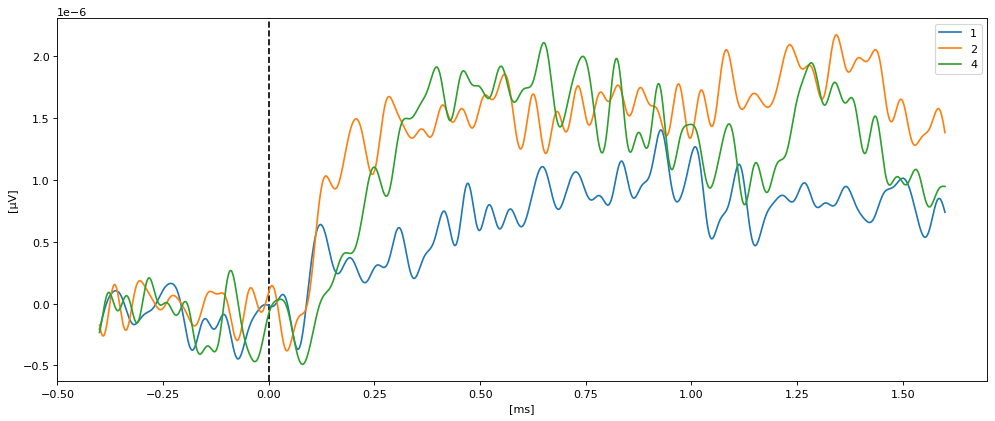

In [28]:
plt.figure(figsize=(15, 6), dpi=80)
plt.axvline(x=0, color='k', linestyle='--')
plt.plot(times, cda_all['1'].mean(0), label='1')
plt.plot(times, cda_all['2'].mean(0), label='2')
plt.plot(times, cda_all['4'].mean(0), label='4')
plt.legend()
plt.ylabel('[μV]')
plt.xlabel('[ms]')
#plt.savefig("./img/Villena-Gonzalez-2019_CDA-reprod.jpg", dpi=300)